# Models
Creates 4 models <br>
Currently a work in progress

In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import math
import warnings
import re
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import matplotlib.pyplot as plt


baseball_path = r"C:\Users\james\Documents\MLB\Data"

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import log_loss, classification_report, f1_score, make_scorer
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier


import joblib

# Create sample dataset

In [3]:
# Read in sample dataset (calculated from API)
sample = pd.read_csv(os.path.join(baseball_path, "Inputs", "Sample100.csv"))
sample['date'] = sample['date'].str.replace("-", "")

In [4]:
# # Append all FanGraphs projections together and save it as a CSV
# batters_list = []
# for filename in os.listdir(r"C:\Users\james\Documents\MLB\Data\A5. Stats - 2. FanGraphs Clean\Batters"):
#     date = filename[12:20]
#     df = pd.read_csv(os.path.join(baseball_path, "A5. Stats - 2. FanGraphs Clean", "Batters", filename), encoding='iso-8859-1')
#     df['date'] = date
    
#     batters_list.append(df)
    
# batters_fg_sample = pd.concat(batters_list, axis=0)

# batters_fg_sample.to_csv(os.path.join(baseball_path, "Inputs", "Batters FanGraphs.csv"))

In [5]:
# # Append all FanGraphs projections together and save it as a CSV
# pitchers_list = []
# for filename in os.listdir(r"C:\Users\james\Documents\MLB\Data\A5. Stats - 2. FanGraphs Clean\Pitchers"):
#     date = filename[13:21]
#     df = pd.read_csv(os.path.join(baseball_path, "A5. Stats - 2. FanGraphs Clean", "Pitchers", filename), encoding='iso-8859-1')
#     df['date'] = date
    
#     pitchers_list.append(df)
    
# pitchers_fg_sample = pd.concat(pitchers_list, axis=0)

# pitchers_fg_sample.to_csv(os.path.join(baseball_path, "Inputs", "Pitchers FanGraphs.csv"))

In [6]:
# Read in FanGraphs batter projections for each day
batters_fg_sample = pd.read_csv(os.path.join(baseball_path, "Inputs", "Batters FanGraphs.csv"))
# Convert date to string for merge
batters_fg_sample['date'] = batters_fg_sample['date'].astype('str')

# Merge sample data with projections
sample = sample.merge(batters_fg_sample, left_on=['batter', 'date'], right_on=['mlbamid', 'date'], how='inner', suffixes=("", "_b"))
# Delete to clear up space
del batters_fg_sample

# Read in FanGraphs pitcher projections for each day
pitchers_fg_sample = pd.read_csv(os.path.join(baseball_path, "Inputs", "Pitchers FanGraphs.csv"))
# Convert date to string for merge
pitchers_fg_sample['date'] = pitchers_fg_sample['date'].astype('str')

# Merge sample data with projections
sample = sample.merge(pitchers_fg_sample, left_on=['pitcher', 'date'], right_on=['mlbamid', 'date'], how='inner', suffixes=("", "_p"))
# Delete to clear up space
del pitchers_fg_sample

C:\Users\james\AppData\Local\Temp\ipykernel_30896\364744879.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  batters_fg_sample = pd.read_csv(os.path.join(baseball_path, "Inputs", "Batters FanGraphs.csv"))
C:\Users\james\AppData\Local\Temp\ipykernel_30896\364744879.py:12: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  pitchers_fg_sample = pd.read_csv(os.path.join(baseball_path, "Inputs", "Pitchers FanGraphs.csv"))
C:\Users\james\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:1214: RuntimeWarning: invalid value encountered in cast
  if not (rk == rk.astype(lk.dtype))[~np.isnan(rk)].all():


# Model Inputs

In [7]:
# Inputs
batter_stats_short = ['b1_b','b2_b','b3_b','hr_b','bb_b','hbp_b',
                'so_b','fo_b','go_b','lo_b','po_b',
                'iso_b','slg_b','obp_b','woba_b',
                'to_left_b','to_middle_b','to_right_b',
                'hard_hit_b','totalDistance_b','launchSpeed_b','maxSpeed_b','maxSpin_b',
                'ab_b','pa_b']

batter_stats_long =  ['b1_b_long','b2_b_long','b3_b_long','hr_b_long','bb_b_long','hbp_b_long',
                'so_b_long','fo_b_long','go_b_long','lo_b_long','po_b_long',
                'iso_b_long','slg_b_long','obp_b_long','woba_b_long',
                'to_left_b_long','to_middle_b_long','to_right_b_long',
                'hard_hit_b_long','totalDistance_b_long','launchSpeed_b_long','maxSpeed_b_long','maxSpin_b_long',
                'ab_b_long','pa_b_long']

pitcher_stats_short = ['b1_p','b2_p','b3_p','hr_p','bb_p','hbp_p',
                 'so_p','fo_p','go_p','lo_p','po_p',
                 'iso_p','slg_p','obp_p','woba_p',
                 'to_left_p','to_middle_p','to_right_p',
                 'hard_hit_p','totalDistance_p','launchSpeed_p','maxSpeed_p','maxSpin_p',
                 'ab_p','pa_p']

pitcher_stats_long = ['b1_p_long','b2_p_long','b3_p_long','hr_p_long','bb_p_long','hbp_p_long',
                 'so_p_long','fo_p_long','go_p_long','lo_p_long','po_p_long',
                 'iso_p_long','slg_p_long','obp_p_long','woba_p_long',
                 'to_left_p_long','to_middle_p_long','to_right_p_long',
                 'hard_hit_p_long','totalDistance_p_long','launchSpeed_p_long','maxSpeed_p_long','maxSpin_p_long',
                 'ab_p_long','pa_p_long']

batter_stats_fg = ['b1_rate','b2_rate','b3_rate','hr_rate','bb_rate','hbp_rate','so_rate', 'woba', 'slg', 'obp']

pitcher_stats_fg = ['H/9','HR/9','K/9','BB/9']


venues = ['venue_1', 'venue_2', 'venue_3', 'venue_4', 'venue_5', 'venue_7', 'venue_10', 'venue_12', 
          'venue_13', 'venue_14', 'venue_15', 'venue_16', 'venue_17', 'venue_19', 'venue_22', 'venue_31', 
          'venue_32', 'venue_680', 'venue_2392', 'venue_2394', 'venue_2395', 'venue_2535', 'venue_2536', 
          'venue_2602', 'venue_2680', 'venue_2681', 'venue_2701', 'venue_2735', 'venue_2756', 'venue_2889', 
          'venue_3289', 'venue_3309', 'venue_3312', 'venue_3313', 'venue_4169', 'venue_4705', 'venue_5010', 
          'venue_5325', 'venue_5365', 'venue_5381', 'venue_5445']

years = ['year_2015', 'year_2016', 'year_2017', 'year_2018', 'year_2019', 'year_2020', 'year_2021', 'year_2022', 'year_2023']

other_list = ['p_L','b_L','x_vect','y_vect','temperature','onFirst','onSecond','onThird','inning','top','score_diff']

In [8]:
# Remove items that do not apply to batters or pitchers
batter_stats_short.remove("maxSpeed_b")
batter_stats_short.remove("maxSpin_b")
batter_stats_long.remove("maxSpeed_b_long")
batter_stats_long.remove("maxSpin_b_long")

pitcher_stats_short.remove("totalDistance_p")
pitcher_stats_long.remove("totalDistance_p_long")
pitcher_stats_short.remove("launchSpeed_p")
pitcher_stats_long.remove("launchSpeed_p_long")


# # Not sure why but these are weird
# batter_stats.remove("launchSpeed_b")
# batter_stats.remove("totalDistance_b")
# batter_stats.remove("launchSpeed_b_long")
# batter_stats.remove("totalDistance_b_long")

# pitcher_stats.remove("maxSpeed_p")
# pitcher_stats.remove("maxSpin_p")
# pitcher_stats.remove("maxSpeed_p_long")
# pitcher_stats.remove("maxSpin_p_long")


# Testing removing these
batter_stats_short.remove('ab_b')
batter_stats_short.remove('pa_b')
batter_stats_long.remove('ab_b_long')
batter_stats_long.remove('pa_b_long')

pitcher_stats_short.remove('ab_p')
pitcher_stats_short.remove('pa_p')
pitcher_stats_long.remove('ab_p_long')
pitcher_stats_long.remove('pa_p_long')

batter_stats = batter_stats_short + batter_stats_long
pitcher_stats = pitcher_stats_short + pitcher_stats_long

In [9]:
# Select variables for each model
# Full batter data, full pitcher data
x_list1 = batter_stats + pitcher_stats + venues + other_list 
# Full batter data, short pitcher data
x_list2 = batter_stats + pitcher_stats_fg + venues + other_list 
# Short batter data, long pitcher data
x_list3 = batter_stats_fg + pitcher_stats + venues + other_list 
# Short batter data, short pitcher data
x_list4 = batter_stats_fg + pitcher_stats_fg + venues + other_list 

print(len(x_list1))
# Variables we want to look at for each model (those we're training on plus names and some basic stats as well as the outcome)
x_list1_plus = x_list1 + ['batterName', 'pitcherName', 'batter', 'pitcher', 'batSide', 'pitchHand', 'eventsModel']
x_list2_plus = x_list2 + ['batterName', 'pitcherName', 'batter', 'pitcher', 'batSide', 'pitchHand', 'eventsModel']
x_list3_plus = x_list3 + ['batterName', 'pitcherName', 'batter', 'pitcher', 'batSide', 'pitchHand', 'eventsModel']
x_list4_plus = x_list4 + ['batterName', 'pitcherName', 'batter', 'pitcher', 'batSide', 'pitchHand', 'eventsModel']

136


# Clean Data

In [11]:
# Get rid of small samples when training
sample = sample.query('pa_b_long >= 40').query('pa_p_long >= 40')

# Get rid of PA outcomes that are not valid outputs
sample = sample.query('eventsModel != "Cut"').reset_index(drop=True)

sample['out'] = sample[['so', 'fo', 'go', 'lo', 'po']].sum(axis=1)
# sample['safe'] = X_merge[['b1', 'b2', 'b3', 'hr', 'bb', 'hbp']].sum(axis=1)


# Note: inner merge of FanGraphs data will remove observations without both batter and pitcher projections

In [12]:
sample.fillna(0, inplace=True)

In [13]:
# Set directory to models folder 
os.chdir(r"C:\Users\james\Documents\MLB\Code\Models")

# Model 1
##### Complete batter variables
##### Complete pitcher variables

In [14]:
# Split into training and testing groups
X_train = sample.groupby(sample['year']).apply(lambda x: x.head(int(len(x)*2/3)))
X_train = X_train[x_list1]
X_test = sample.groupby(sample['year']).apply(lambda x: x.tail(int(len(x)*1/3)))
X_test = X_test[x_list1]
y_train = sample.groupby(sample['year']).apply(lambda x: x.head(int(len(x)*2/3)))
y_train = y_train['eventsModel']
y_test = sample.groupby(sample['year']).apply(lambda x: x.tail(int(len(x)*1/3)))
y_test = y_test['eventsModel']

In [15]:
# Scale (hopefully deprecated)
scaler = StandardScaler()
X_train.sort_index(inplace=True)
y_train.sort_index(inplace=True)
X_test.sort_index(inplace=True)
y_test.sort_index(inplace=True)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

In [17]:
len(x_list1)
print(np.sqrt(len(x_list1)*11))

38.67815921162743


In [37]:
%%time
# MLPClassifier(hidden_layer_sizes=(40,40), activation='relu', verbose=True, alpha=0.0001, early_stopping=True, validation_fraction=0.1, random_state=1, max_iter=iters),

# MLPClassifier(hidden_layer_sizes=layers, activation='relu', verbose=True, alpha=0.0001, early_stopping=True, validation_fraction=0.10, random_state=1, max_iter=iters),
# MLPClassifier(hidden_layer_sizes=layers, activation='relu', verbose=True, alpha=0.0001, early_stopping=True, validation_fraction=0.12, random_state=1, max_iter=iters),

#1, 5, 27 (weaker), 28, 35(weaker)

layers = (40,40)
# layers=(39,39,39,39,39)
layers_str = ''.join(str(x) for x in layers)

iters = 10

filename = "model1_" + layers_str + "_100se.sav"

# Define the individual models in the ensemble
models = [
    # OneVsRestClassifier(MLPClassifier(hidden_layer_sizes=layers, activation='relu', verbose=True, alpha=0.0001, early_stopping=True, validation_fraction=0.10, random_state=1, max_iter=iters))
    # MLPClassifier(hidden_layer_sizes=layers, activation='relu', verbose=True, alpha=0.0001, early_stopping=True, validation_fraction=0.10, random_state=1, max_iter=iters),
    # MLPClassifier(hidden_layer_sizes=layers, activation='relu', verbose=True, alpha=0.0001, early_stopping=True, validation_fraction=0.12, random_state=1, max_iter=iters),
    MLPClassifier(hidden_layer_sizes=(layers), activation='logistic', verbose=True, alpha=0.0001, early_stopping=True, validation_fraction=0.1, random_state=1, max_iter=iters),
    MLPClassifier(hidden_layer_sizes=(layers), activation='relu', verbose=True, alpha=0.0001, early_stopping=True, validation_fraction=0.1, random_state=5, max_iter=iters),
    # MLPClassifier(hidden_layer_sizes=(layers), activation='relu', verbose=True, alpha=0.0001, early_stopping=True, validation_fraction=0.1, random_state=27, max_iter=iters),
    MLPClassifier(hidden_layer_sizes=(layers), activation='relu', verbose=True, alpha=0.0001, early_stopping=True, validation_fraction=0.1, random_state=28, max_iter=iters),
    # MLPClassifier(hidden_layer_sizes=(layers), activation='relu', verbose=True, alpha=0.0001, early_stopping=True, validation_fraction=0.1, random_state=35, max_iter=iters),
]

# Create the ensemble classifier using VotingClassifier
# model1 = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=-2).fit(sample[x_list1], sample[['eventsModel']].values.ravel())
model1 = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=-2).fit(X_train, y_train)

# Save model
pickle.dump(model1, open(filename, 'wb'))

CPU times: total: 781 ms
Wall time: 1min 58s


In [38]:
# Keep relevant variables in dataset
sample1 = sample[x_list1_plus].reset_index()
# Rename index to make a merge ID
sample1.rename(columns={'index':'merge'}, inplace=True)

# Predict PA probabilities
try:
    X_test.drop(columns={'b1', 'b2', 'b3', 'bb', 'fo', 'go', 'hbp', 'hr', 'lo', 'po', 'so'}, inplace=True)
except:
    pass

X_test[['b1', 'b2', 'b3', 'bb', 'fo', 'go', 'hbp', 'hr', 'lo', 'po', 'so']] = model1.predict_proba(X_test)

# Keep PA probabilities
X_merge = X_test[['b1', 'b2', 'b3', 'bb', 'fo', 'go', 'hbp', 'hr', 'lo', 'po', 'so']].reset_index()
# Rename index to make a merge ID
X_merge.rename(columns={'level_1':'merge'}, inplace=True)

# Merge PA probabilities in test sample onto full sample, keeping those that merge
X_merge = X_merge.merge(sample1, on='merge', how='inner')

In [39]:
X_merge['outs'] = X_merge[['so', 'fo', 'go', 'lo', 'po']].sum(axis=1)
X_merge.loc[X_merge['eventsModel'].isin(['so', 'fo', 'go', 'lo', 'po']), 'outs_act'] = 1
X_merge['outs_act'].fillna(0, inplace=True)

X_merge['decile'] = pd.qcut(X_merge['outs'], 10, labels=False)
out_df = X_merge.groupby('decile').mean().reset_index()

var = "so"
X_merge[f'{var}_act'] = (X_merge['eventsModel'] == var).astype('int')
X_merge['decile'] = pd.qcut(X_merge[var], 10, labels=False)

df_name = var + "_df"
globals()[df_name] = X_merge.groupby('decile').mean().reset_index()

var = "go"
X_merge[f'{var}_act'] = (X_merge['eventsModel'] == var).astype('int')
X_merge['decile'] = pd.qcut(X_merge[var], 10, labels=False)

df_name = var + "_df"
globals()[df_name] = X_merge.groupby('decile').mean().reset_index()

var = "hr"
X_merge[f'{var}_act'] = (X_merge['eventsModel'] == var).astype('int')
X_merge['decile'] = pd.qcut(X_merge[var], 4, labels=False)

df_name = var + "_df"
globals()[df_name] = X_merge.groupby('decile').mean().reset_index()

var = "b1"
X_merge[f'{var}_act'] = (X_merge['eventsModel'] == var).astype('int')
X_merge['decile'] = pd.qcut(X_merge[var], 10, labels=False)

df_name = var + "_df"
globals()[df_name] = X_merge.groupby('decile').mean().reset_index()

var = "b2"
X_merge[f'{var}_act'] = (X_merge['eventsModel'] == var).astype('int')
X_merge['decile'] = pd.qcut(X_merge[var], 4, labels=False)

df_name = var + "_df"
globals()[df_name] = X_merge.groupby('decile').mean().reset_index()

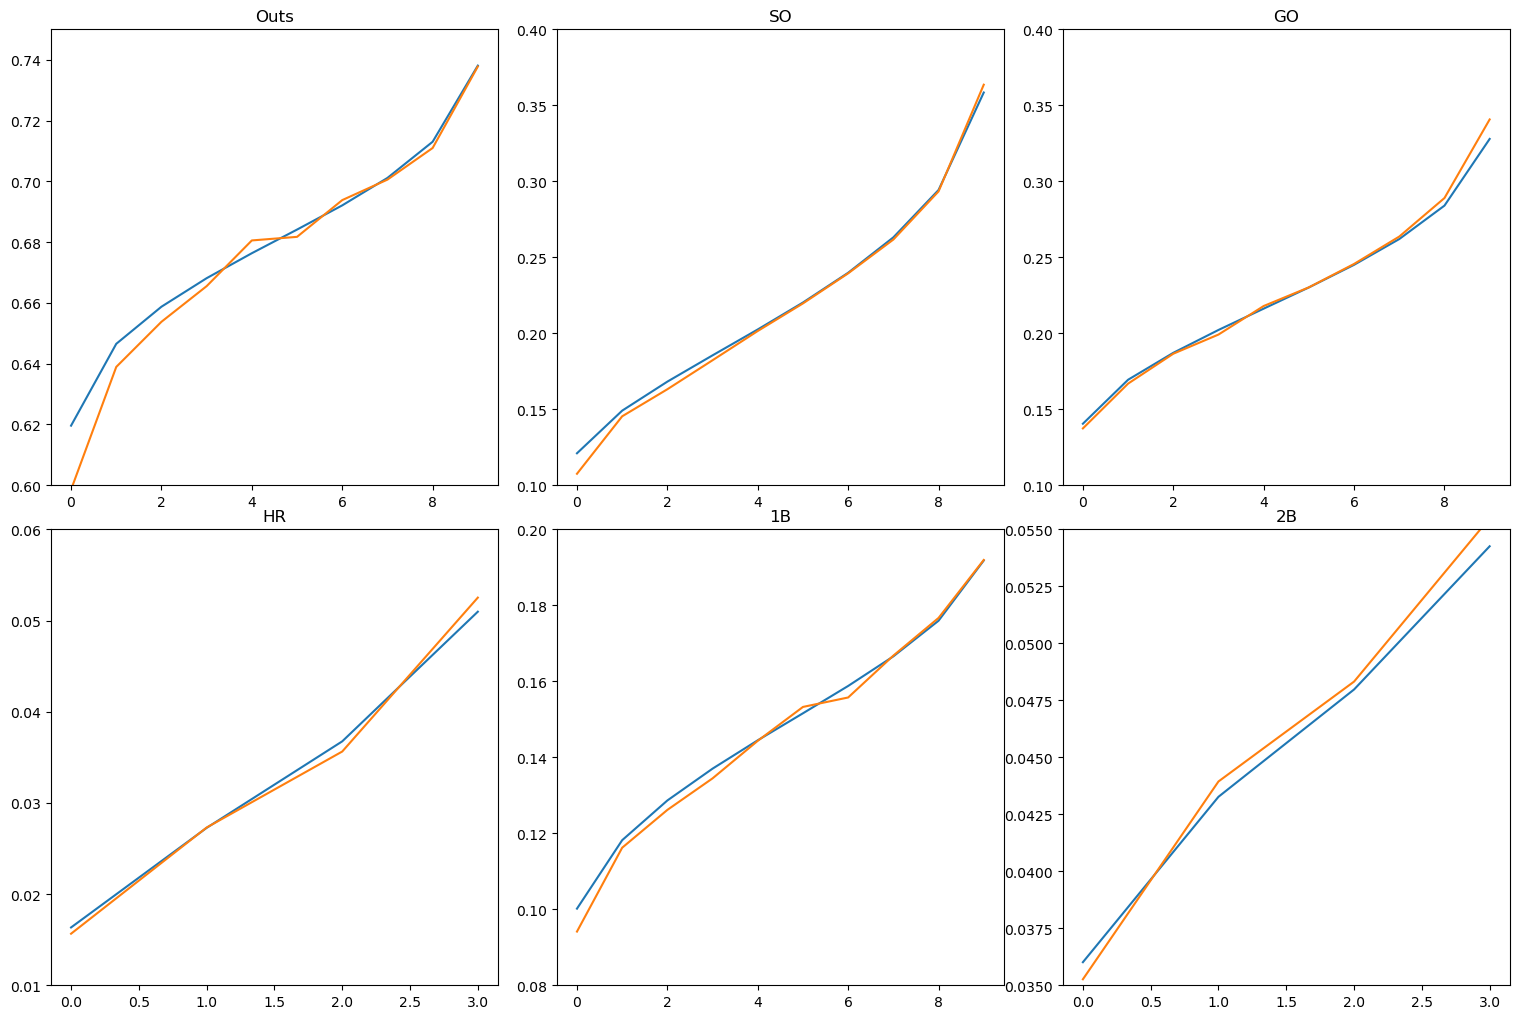

In [40]:
fig, axs = plt.subplots(2, 3, figsize=(15,10))  # Create a grid of 2x2 subplots
# fig.suptitle('A Grid of Subplots')

# # Plot data on each subplot
axs[0, 0].plot(out_df['decile'], out_df['outs'])
axs[0, 0].plot(out_df['decile'], out_df['outs_act'])
axs[0, 0].set_ylim(0.6,0.75) 
axs[0, 0].set_title('Outs')

axs[0, 1].plot(so_df['decile'], so_df['so'])
axs[0, 1].plot(so_df['decile'], so_df['so_act'])
axs[0, 1].set_ylim(0.1,0.4) 
axs[0, 1].set_title('SO')

axs[0, 2].plot(go_df['decile'], go_df['go'])
axs[0, 2].plot(go_df['decile'], go_df['go_act'])
axs[0, 2].set_ylim(0.1,0.4) 
axs[0, 2].set_title('GO')

axs[1, 0].plot(hr_df['decile'], hr_df['hr'])
axs[1, 0].plot(hr_df['decile'], hr_df['hr_act'])
axs[1, 0].set_ylim(0.01,0.06)   
axs[1, 0].set_title('HR')

axs[1, 1].plot(b1_df['decile'], b1_df['b1'])
axs[1, 1].plot(b1_df['decile'], b1_df['b1_act'])
axs[1, 1].set_ylim(0.08,0.2) 
axs[1, 1].set_title('1B')

axs[1, 2].plot(b2_df['decile'], b2_df['b2'])
axs[1, 2].plot(b2_df['decile'], b2_df['b2_act'])
axs[1, 2].set_ylim(0.035,0.055)   
axs[1, 2].set_title('2B')

# Add some space between subplots to prevent overlapping
fig.tight_layout(pad=.0)

# Show the figure
plt.show()


# Model 2
##### Complete batter variables
##### Short pitcher variables

In [106]:
# Split into training and testing groups
X_train = sample.groupby(sample['year']).apply(lambda x: x.head(int(len(x)*2/3)))
X_train = X_train[x_list2]
X_test = sample.groupby(sample['year']).apply(lambda x: x.tail(int(len(x)*1/3)))
X_test = X_test[x_list2]
y_train = sample.groupby(sample['year']).apply(lambda x: x.head(int(len(x)*2/3)))
y_train = y_train['eventsModel']
y_test = sample.groupby(sample['year']).apply(lambda x: x.tail(int(len(x)*1/3)))
y_test = y_test['eventsModel']

In [108]:
# Scale
scaler = StandardScaler()
X_train.sort_index(inplace=True)
y_train.sort_index(inplace=True)
X_test.sort_index(inplace=True)
y_test.sort_index(inplace=True)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [109]:
print(len(x_list2))
print((len(x_list2) + 11)/2)

98
54.5


In [192]:
layers = (99,99)
layers_str = ''.join(str(x) for x in layers)
iters = 15

filename = "model2_" + layers_str + "_100se.sav"

# Define the individual models in the ensemble
models = [
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', verbose=True, alpha=0.0001, random_state=7, max_iter=iters),
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', verbose=True, alpha=0.0001, random_state=8, max_iter=iters),
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', verbose=True, alpha=0.0001, random_state=9, max_iter=iters),
]

# Create the ensemble classifier using VotingClassifier
model2 = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft').fit(sample[x_list2], sample[['eventsModel']].values.ravel())


# Train model
pickle.dump(model2, open(filename, 'wb'))

Iteration 1, loss = 2.04270965
Iteration 2, loss = 2.02410646
Iteration 3, loss = 2.02130618
Iteration 4, loss = 2.01918578
Iteration 5, loss = 2.01762171
Iteration 6, loss = 2.01656172
Iteration 7, loss = 2.01551564
Iteration 8, loss = 2.01441970
Iteration 9, loss = 2.01340880
Iteration 10, loss = 2.01275475
Iteration 11, loss = 2.01181906
Iteration 12, loss = 2.01118843
Iteration 13, loss = 2.01046746
Iteration 14, loss = 2.01004014
Iteration 15, loss = 2.00955371


C:\Users\james\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.04152130
Iteration 2, loss = 2.02389430
Iteration 3, loss = 2.02076409
Iteration 4, loss = 2.01899221
Iteration 5, loss = 2.01770144
Iteration 6, loss = 2.01667977
Iteration 7, loss = 2.01575343
Iteration 8, loss = 2.01497127
Iteration 9, loss = 2.01372760
Iteration 10, loss = 2.01302277
Iteration 11, loss = 2.01235761
Iteration 12, loss = 2.01155870
Iteration 13, loss = 2.01104677
Iteration 14, loss = 2.01026461
Iteration 15, loss = 2.00957436


C:\Users\james\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 2.04726804
Iteration 2, loss = 2.02427976
Iteration 3, loss = 2.02089124
Iteration 4, loss = 2.01870439
Iteration 5, loss = 2.01715901
Iteration 6, loss = 2.01583894
Iteration 7, loss = 2.01452140
Iteration 8, loss = 2.01333850
Iteration 9, loss = 2.01208018
Iteration 10, loss = 2.01112693
Iteration 11, loss = 2.01010739
Iteration 12, loss = 2.00910385
Iteration 13, loss = 2.00823820
Iteration 14, loss = 2.00739338
Iteration 15, loss = 2.00663386


C:\Users\james\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(


In [193]:
# Keep relevant variables in dataset
sample2 = sample[x_list2_plus].reset_index()
# Rename index to make a merge ID
sample2.rename(columns={'index':'merge'}, inplace=True)

# Predict PA probabilities
try:
    X_test.drop(columns={'b1', 'b2', 'b3', 'bb', 'fo', 'go', 'hbp', 'hr', 'lo', 'po', 'so'}, inplace=True)
except:
    pass

# Predict PA probabilities
X_test[['b1', 'b2', 'b3', 'bb', 'fo', 'go', 'hbp', 'hr', 'lo', 'po', 'so']] = model2.predict_proba(X_test)

# Keep PA probabilities
X_merge = X_test[['b1', 'b2', 'b3', 'bb', 'fo', 'go', 'hbp', 'hr', 'lo', 'po', 'so']].reset_index()
# Rename index to make a merge ID
X_merge.rename(columns={'level_1':'merge'}, inplace=True)

# Merge PA probabilities in test sample onto full sample, keeping those that merge
X_merge = X_merge.merge(sample2, on='merge', how='inner')
X_merge

,year,merge,b1,b2,b3,bb,fo,go,hbp,hr,...,inning,top,score_diff,batterName,pitcherName,batter,pitcher,batSide,pitchHand,eventsModel
0,2015,85818,0.177600,0.069272,0.005839,0.061508,0.102708,0.285951,0.004393,0.051142,...,4,0,2.0,Travis Shaw,Johnny Cueto,543768,456501,L,R,so
1,2015,85819,0.177600,0.069272,0.005839,0.061508,0.102708,0.285951,0.004393,0.051142,...,4,0,2.0,Travis Shaw,Johnny Cueto,543768,456501,L,R,so
2,2015,85820,0.177600,0.069272,0.005839,0.061508,0.102708,0.285951,0.004393,0.051142,...,4,0,2.0,Travis Shaw,Johnny Cueto,543768,456501,L,R,so
3,2015,85821,0.177600,0.069272,0.005839,0.061508,0.102708,0.285951,0.004393,0.051142,...,4,0,2.0,Travis Shaw,Johnny Cueto,543768,456501,L,R,so
4,2015,85822,0.181603,0.068537,0.005016,0.058599,0.106181,0.283135,0.004775,0.048771,...,5,0,4.0,Travis Shaw,Johnny Cueto,543768,456501,L,R,so
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421840,2023,1265543,0.149846,0.051677,0.002336,0.096963,0.124536,0.236784,0.007033,0.035021,...,6,0,0.0,AJ Pollock,Zack Thompson,572041,668868,R,L,lo
421841,2023,1265544,0.149591,0.039327,0.003005,0.091758,0.098920,0.279877,0.016445,0.011874,...,7,0,0.0,Kolten Wong,Zack Thompson,543939,668868,L,L,bb
421842,2023,1265545,0.159892,0.043238,0.003276,0.112367,0.105859,0.263863,0.012643,0.015448,...,7,0,0.0,J.P. Crawford,Zack Thompson,641487,668868,L,L,b1
421843,2023,1265546,0.117254,0.038748,0.002497,0.107325,0.110971,0.206075,0.013444,0.026519,...,8,0,2.0,Jarred Kelenic,Genesis Cabrera,672284,650893,L,L,go


In [194]:
X_merge['outs'] = X_merge[['so', 'fo', 'go', 'lo', 'po']].sum(axis=1)
X_merge.loc[X_merge['eventsModel'].isin(['so', 'fo', 'go', 'lo', 'po']), 'outs_act'] = 1
X_merge['outs_act'].fillna(0, inplace=True)

X_merge['decile'] = pd.qcut(X_merge['outs'], 10, labels=False)
out_df = X_merge.groupby('decile').mean().reset_index()

var = "so"
X_merge[f'{var}_act'] = (X_merge['eventsModel'] == var).astype('int')
X_merge['decile'] = pd.qcut(X_merge[var], 10, labels=False)

df_name = var + "_df"
globals()[df_name] = X_merge.groupby('decile').mean().reset_index()

var = "go"
X_merge[f'{var}_act'] = (X_merge['eventsModel'] == var).astype('int')
X_merge['decile'] = pd.qcut(X_merge[var], 10, labels=False)

df_name = var + "_df"
globals()[df_name] = X_merge.groupby('decile').mean().reset_index()

var = "hr"
X_merge[f'{var}_act'] = (X_merge['eventsModel'] == var).astype('int')
X_merge['decile'] = pd.qcut(X_merge[var], 10, labels=False)

df_name = var + "_df"
globals()[df_name] = X_merge.groupby('decile').mean().reset_index()

var = "b1"
X_merge[f'{var}_act'] = (X_merge['eventsModel'] == var).astype('int')
X_merge['decile'] = pd.qcut(X_merge[var], 10, labels=False)

df_name = var + "_df"
globals()[df_name] = X_merge.groupby('decile').mean().reset_index()

var = "b2"
X_merge[f'{var}_act'] = (X_merge['eventsModel'] == var).astype('int')
X_merge['decile'] = pd.qcut(X_merge[var], 10, labels=False)

df_name = var + "_df"
globals()[df_name] = X_merge.groupby('decile').mean().reset_index()

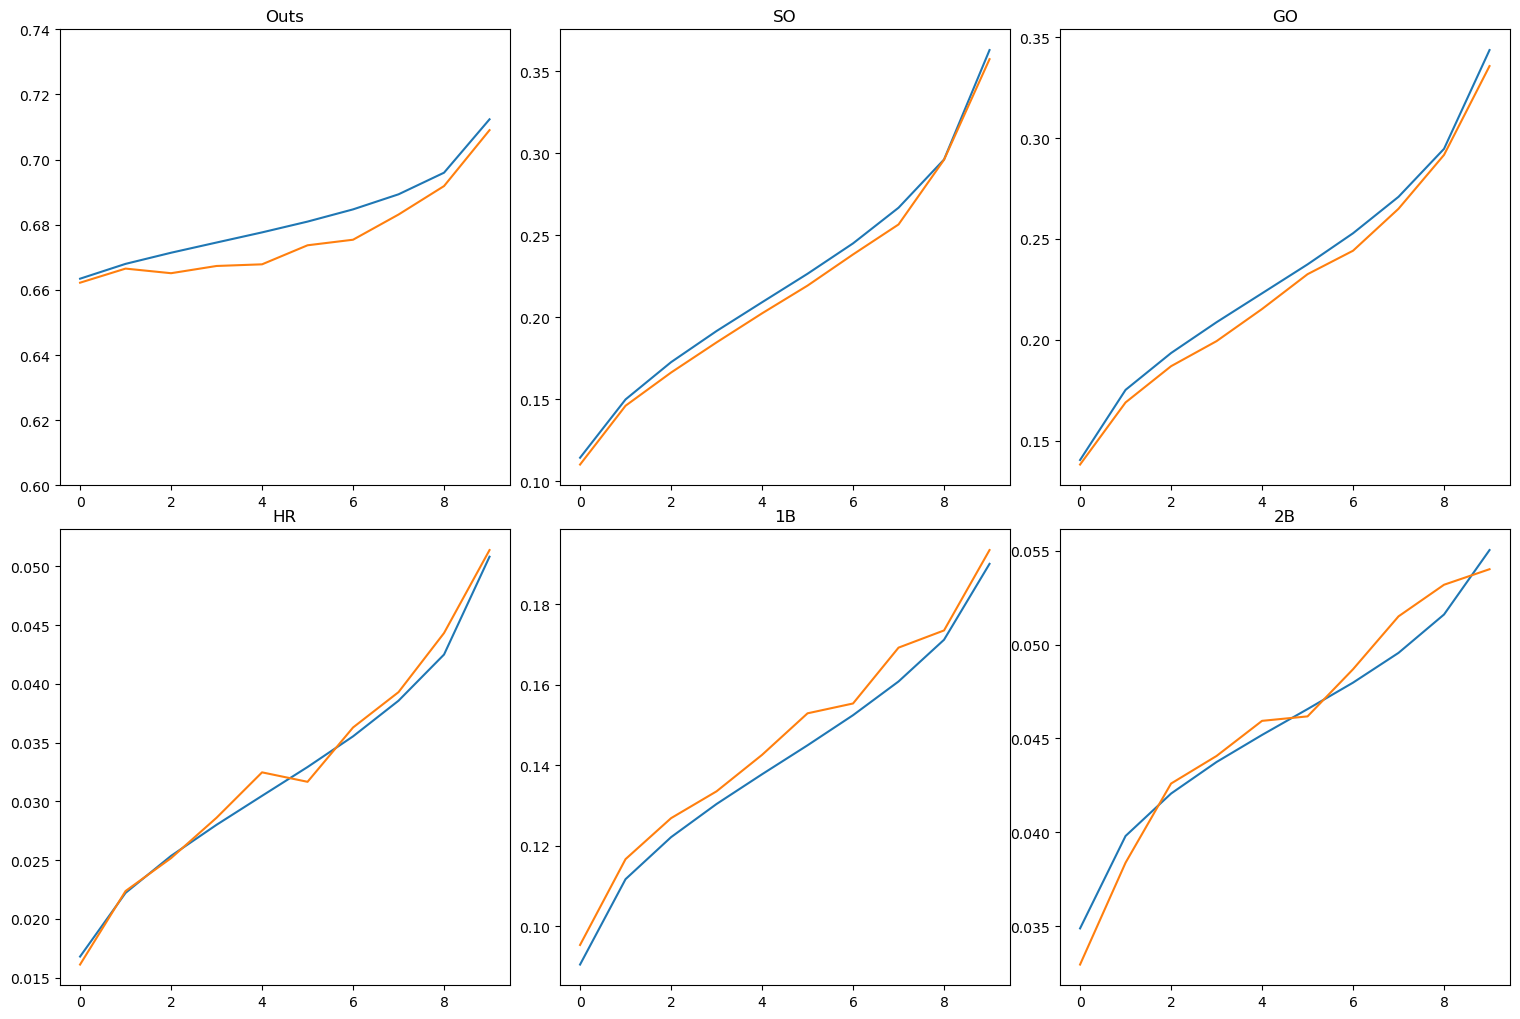

In [46]:
fig, axs = plt.subplots(2, 3, figsize=(15,10))  # Create a grid of 2x2 subplots
# fig.suptitle('A Grid of Subplots')

# # Plot data on each subplot
axs[0, 0].plot(out_df['decile'], out_df['outs'])
axs[0, 0].plot(out_df['decile'], out_df['outs_act'])
# axs[0, 0].set_ylim(.6, .74)    # Set y-axis limits for the first subplot
axs[0, 0].set_title('Outs')

axs[0, 1].plot(so_df['decile'], so_df['so'])
axs[0, 1].plot(so_df['decile'], so_df['so_act'])
axs[0, 1].set_title('SO')

axs[0, 2].plot(go_df['decile'], go_df['go'])
axs[0, 2].plot(go_df['decile'], go_df['go_act'])
axs[0, 2].set_title('GO')

axs[1, 0].plot(hr_df['decile'], hr_df['hr'])
axs[1, 0].plot(hr_df['decile'], hr_df['hr_act'])
axs[1, 0].set_title('HR')

axs[1, 1].plot(b1_df['decile'], b1_df['b1'])
axs[1, 1].plot(b1_df['decile'], b1_df['b1_act'])
axs[1, 1].set_title('1B')

axs[1, 2].plot(b2_df['decile'], b2_df['b2'])
axs[1, 2].plot(b2_df['decile'], b2_df['b2_act'])
axs[1, 2].set_title('2B')

# Add some space between subplots to prevent overlapping
fig.tight_layout(pad=.0)

# Show the figure
plt.show()

# Model 3
##### Short batter variables
##### Complete pitcher variables

In [83]:
# Split into training and testing groups
X_train = sample.groupby(sample['year']).apply(lambda x: x.head(int(len(x)*2/3)))
X_train = X_train[x_list3]
X_test = sample.groupby(sample['year']).apply(lambda x: x.tail(int(len(x)*1/3)))
X_test = X_test[x_list3]
y_train = sample.groupby(sample['year']).apply(lambda x: x.head(int(len(x)*2/3)))
y_train = y_train['eventsModel']
y_test = sample.groupby(sample['year']).apply(lambda x: x.tail(int(len(x)*1/3)))
y_test = y_test['eventsModel']

In [84]:
# Scale
scaler = StandardScaler()
X_train.sort_index(inplace=True)
y_train.sort_index(inplace=True)
X_test.sort_index(inplace=True)
y_test.sort_index(inplace=True)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [85]:
print(len(x_list3))
print((len(x_list3) + 12)/2)


104
58.0


In [86]:
layers = (58,58)
layers_str = ''.join(str(x) for x in layers)

iters = 250

filename = "model3_" + layers_str + "_100se.sav"

# Define the individual models in the ensemble
models = [
    # MLPClassifier(hidden_layer_sizes=layers, activation='relu', verbose=True, alpha=0.0001, early_stopping=True, validation_fraction=0.1, random_state=1, max_iter=iters),
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', verbose=True, alpha=0.0001, early_stopping=True, validation_fraction=0.1, random_state=2, max_iter=iters),
    # MLPClassifier(hidden_layer_sizes=layers, activation='relu', verbose=True, alpha=0.0001, early_stopping=True, validation_fraction=0.1, random_state=4, max_iter=iters),
]

# Create the ensemble classifier using VotingClassifier
model3 = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft').fit(sample[x_list3], sample[['eventsModel']].values.ravel())


# Train model
pickle.dump(model3, open(filename, 'wb'))

KeyboardInterrupt: 

In [ ]:
# Keep relevant variables in dataset
sample3 = sample[x_list3_plus].reset_index()
# Rename index to make a merge ID
sample3.rename(columns={'index':'merge'}, inplace=True)

# Predict PA probabilities
try:
    X_test.drop(columns={'b1', 'b2', 'b3', 'bb', 'fo', 'go', 'hbp', 'hr', 'lo', 'po', 'so'}, inplace=True)
except:
    pass

# Predict PA probabilities
X_test[['b1', 'b2', 'b3', 'bb', 'fo', 'go', 'hbp', 'hr', 'lo', 'po', 'so']] = model3.predict_proba(X_test)

# Keep PA probabilities
X_merge = X_test[['b1', 'b2', 'b3', 'bb', 'fo', 'go', 'hbp', 'hr', 'lo', 'po', 'so']].reset_index()
# Rename index to make a merge ID
X_merge.rename(columns={'level_1':'merge'}, inplace=True)

# Merge PA probabilities in test sample onto full sample, keeping those that merge
X_merge = X_merge.merge(sample3, on='merge', how='inner')
X_merge

In [ ]:
X_merge['outs'] = X_merge[['so', 'fo', 'go', 'lo', 'po']].sum(axis=1)
X_merge.loc[X_merge['eventsModel'].isin(['so', 'fo', 'go', 'lo', 'po']), 'outs_act'] = 1
X_merge['outs_act'].fillna(0, inplace=True)

X_merge['decile'] = pd.qcut(X_merge['outs'], 10, labels=False)
out_df = X_merge.groupby('decile').mean().reset_index()

var = "so"
X_merge[f'{var}_act'] = (X_merge['eventsModel'] == var).astype('int')
X_merge['decile'] = pd.qcut(X_merge[var], 10, labels=False)

df_name = var + "_df"
globals()[df_name] = X_merge.groupby('decile').mean().reset_index()

var = "go"
X_merge[f'{var}_act'] = (X_merge['eventsModel'] == var).astype('int')
X_merge['decile'] = pd.qcut(X_merge[var], 10, labels=False)

df_name = var + "_df"
globals()[df_name] = X_merge.groupby('decile').mean().reset_index()

var = "hr"
X_merge[f'{var}_act'] = (X_merge['eventsModel'] == var).astype('int')
X_merge['decile'] = pd.qcut(X_merge[var], 10, labels=False)

df_name = var + "_df"
globals()[df_name] = X_merge.groupby('decile').mean().reset_index()

var = "b1"
X_merge[f'{var}_act'] = (X_merge['eventsModel'] == var).astype('int')
X_merge['decile'] = pd.qcut(X_merge[var], 10, labels=False)

df_name = var + "_df"
globals()[df_name] = X_merge.groupby('decile').mean().reset_index()

var = "b2"
X_merge[f'{var}_act'] = (X_merge['eventsModel'] == var).astype('int')
X_merge['decile'] = pd.qcut(X_merge[var], 10, labels=False)

df_name = var + "_df"
globals()[df_name] = X_merge.groupby('decile').mean().reset_index()

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15,10))  # Create a grid of 2x2 subplots
# fig.suptitle('A Grid of Subplots')

# # Plot data on each subplot
axs[0, 0].plot(out_df['decile'], out_df['outs'])
axs[0, 0].plot(out_df['decile'], out_df['outs_act'])
axs[0, 0].set_title('Outs')

axs[0, 1].plot(so_df['decile'], so_df['so'])
axs[0, 1].plot(so_df['decile'], so_df['so_act'])
axs[0, 1].set_title('SO')

axs[0, 2].plot(go_df['decile'], go_df['go'])
axs[0, 2].plot(go_df['decile'], go_df['go_act'])
axs[0, 2].set_title('GO')

axs[1, 0].plot(hr_df['decile'], hr_df['hr'])
axs[1, 0].plot(hr_df['decile'], hr_df['hr_act'])
axs[1, 0].set_title('HR')

axs[1, 1].plot(b1_df['decile'], b1_df['b1'])
axs[1, 1].plot(b1_df['decile'], b1_df['b1_act'])
axs[1, 1].set_title('1B')

axs[1, 2].plot(b2_df['decile'], b2_df['b2'])
axs[1, 2].plot(b2_df['decile'], b2_df['b2_act'])
axs[1, 2].set_title('2B')

# Add some space between subplots to prevent overlapping
fig.tight_layout(pad=.0)

# Show the figure
plt.show()

# Model 4
##### Short batter variables
##### Short pitcher variables

In [13]:
# Split into training and testing groups
X_train = sample.groupby(sample['year']).apply(lambda x: x.head(int(len(x)*2/3)))
X_train = X_train[x_list4]
X_test = sample.groupby(sample['year']).apply(lambda x: x.tail(int(len(x)*1/3)))
X_test = X_test[x_list4]
y_train = sample.groupby(sample['year']).apply(lambda x: x.head(int(len(x)*2/3)))
y_train = y_train['eventsModel']
y_test = sample.groupby(sample['year']).apply(lambda x: x.tail(int(len(x)*1/3)))
y_test = y_test['eventsModel']

In [14]:
# Scale
scaler = StandardScaler()
X_train.sort_index(inplace=True)
y_train.sort_index(inplace=True)
X_test.sort_index(inplace=True)
y_test.sort_index(inplace=True)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
print(len(x_list4))

66


In [52]:
layers = (66,44)
layers_str = ''.join(str(x) for x in layers)

filename = "model4_" + layers_str + "_100se.sav"

iters = 300

# Define the individual models in the ensemble
models = [
    # MLPClassifier(hidden_layer_sizes=layers, activation='relu', verbose=True, alpha=0.001, early_stopping=True, validation_fraction=0.1, random_state=1, max_iter=iters),
    # MLPClassifier(hidden_layer_sizes=layers, activation='relu', verbose=True, alpha=0.001, early_stopping=True, validation_fraction=0.1, random_state=4, max_iter=iters),
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', verbose=True, alpha=0.001, early_stopping=True, validation_fraction=0.1, random_state=14, max_iter=iters),
]

# Create the ensemble classifier using VotingClassifier
model4 = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft').fit(sample[x_list4], sample[['eventsModel']].values.ravel())


# Train model
pickle.dump(model4, open(filename, 'wb'))

Iteration 1, loss = 2.05155888
Validation score: 0.262360
Iteration 2, loss = 2.03324197
Validation score: 0.266343
Iteration 3, loss = 2.02952149
Validation score: 0.264209
Iteration 4, loss = 2.02756401
Validation score: 0.268247
Iteration 5, loss = 2.02629490
Validation score: 0.266825
Iteration 6, loss = 2.02525592
Validation score: 0.268531
Iteration 7, loss = 2.02451833
Validation score: 0.268192
Iteration 8, loss = 2.02377409
Validation score: 0.269187
Iteration 9, loss = 2.02335728
Validation score: 0.267402
Iteration 10, loss = 2.02288909
Validation score: 0.268381
Iteration 11, loss = 2.02247267
Validation score: 0.269551
Iteration 12, loss = 2.02211743
Validation score: 0.268081
Iteration 13, loss = 2.02193445
Validation score: 0.269021
Iteration 14, loss = 2.02164811
Validation score: 0.269535
Iteration 15, loss = 2.02149710
Validation score: 0.269709
Iteration 16, loss = 2.02133315
Validation score: 0.267457
Iteration 17, loss = 2.02121709
Validation score: 0.268247
Iterat

In [53]:
# Keep relevant variables in dataset
sample4 = sample[x_list4_plus].reset_index()
# Rename index to make a merge ID
sample4.rename(columns={'index':'merge'}, inplace=True)

# Predict PA probabilities
try:
    X_test.drop(columns={'b1', 'b2', 'b3', 'bb', 'fo', 'go', 'hbp', 'hr', 'lo', 'po', 'so'}, inplace=True)
except:
    pass

# Predict PA probabilities
X_test[['b1', 'b2', 'b3', 'bb', 'fo', 'go', 'hbp', 'hr', 'lo', 'po', 'so']] = model4.predict_proba(X_test)

# Keep PA probabilities
X_merge = X_test[['b1', 'b2', 'b3', 'bb', 'fo', 'go', 'hbp', 'hr', 'lo', 'po', 'so']].reset_index()
# Rename index to make a merge ID
X_merge.rename(columns={'level_1':'merge'}, inplace=True)

# Merge PA probabilities in test sample onto full sample, keeping those that merge
X_merge = X_merge.merge(sample4, on='merge', how='inner')
X_merge

,year,merge,b1,b2,b3,bb,fo,go,hbp,hr,...,inning,top,score_diff,batterName,pitcherName,batter,pitcher,batSide,pitchHand,eventsModel
0,2015,85818,0.154771,0.054912,0.007664,0.066450,0.115969,0.246096,0.008128,0.035653,...,4,0,2.0,Travis Shaw,Johnny Cueto,543768,456501,L,R,so
1,2015,85819,0.154771,0.054912,0.007664,0.066450,0.115969,0.246096,0.008128,0.035653,...,4,0,2.0,Travis Shaw,Johnny Cueto,543768,456501,L,R,so
2,2015,85820,0.154888,0.054965,0.007601,0.066837,0.116069,0.246270,0.008131,0.035782,...,4,0,2.0,Travis Shaw,Johnny Cueto,543768,456501,L,R,so
3,2015,85821,0.154888,0.054965,0.007601,0.066837,0.116069,0.246270,0.008131,0.035782,...,4,0,2.0,Travis Shaw,Johnny Cueto,543768,456501,L,R,so
4,2015,85822,0.164193,0.057327,0.008217,0.057610,0.120520,0.250505,0.007941,0.034682,...,5,0,4.0,Travis Shaw,Johnny Cueto,543768,456501,L,R,so
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421840,2023,1265543,0.139944,0.044016,0.002282,0.099356,0.122117,0.227905,0.009377,0.026839,...,6,0,0.0,AJ Pollock,Zack Thompson,572041,668868,R,L,lo
421841,2023,1265544,0.147836,0.033316,0.002307,0.083236,0.099130,0.281380,0.016108,0.013576,...,7,0,0.0,Kolten Wong,Zack Thompson,543939,668868,L,L,bb
421842,2023,1265545,0.153995,0.034510,0.002852,0.084823,0.086837,0.310092,0.021617,0.012077,...,7,0,0.0,J.P. Crawford,Zack Thompson,641487,668868,L,L,b1
421843,2023,1265546,0.113179,0.033290,0.002156,0.100538,0.105277,0.197898,0.017599,0.023663,...,8,0,2.0,Jarred Kelenic,Genesis Cabrera,672284,650893,L,L,go


In [54]:
X_merge['outs'] = X_merge[['so', 'fo', 'go', 'lo', 'po']].sum(axis=1)
X_merge.loc[X_merge['eventsModel'].isin(['so', 'fo', 'go', 'lo', 'po']), 'outs_act'] = 1
X_merge['outs_act'].fillna(0, inplace=True)

X_merge['decile'] = pd.qcut(X_merge['outs'], 10, labels=False)
out_df = X_merge.groupby('decile').mean().reset_index()

var = "so"
X_merge[f'{var}_act'] = (X_merge['eventsModel'] == var).astype('int')
X_merge['decile'] = pd.qcut(X_merge[var], 10, labels=False)

df_name = var + "_df"
globals()[df_name] = X_merge.groupby('decile').mean().reset_index()

var = "go"
X_merge[f'{var}_act'] = (X_merge['eventsModel'] == var).astype('int')
X_merge['decile'] = pd.qcut(X_merge[var], 10, labels=False)

df_name = var + "_df"
globals()[df_name] = X_merge.groupby('decile').mean().reset_index()

var = "hr"
X_merge[f'{var}_act'] = (X_merge['eventsModel'] == var).astype('int')
X_merge['decile'] = pd.qcut(X_merge[var], 10, labels=False)

df_name = var + "_df"
globals()[df_name] = X_merge.groupby('decile').mean().reset_index()

var = "b1"
X_merge[f'{var}_act'] = (X_merge['eventsModel'] == var).astype('int')
X_merge['decile'] = pd.qcut(X_merge[var], 10, labels=False)

df_name = var + "_df"
globals()[df_name] = X_merge.groupby('decile').mean().reset_index()

var = "b2"
X_merge[f'{var}_act'] = (X_merge['eventsModel'] == var).astype('int')
X_merge['decile'] = pd.qcut(X_merge[var], 10, labels=False)

df_name = var + "_df"
globals()[df_name] = X_merge.groupby('decile').mean().reset_index()

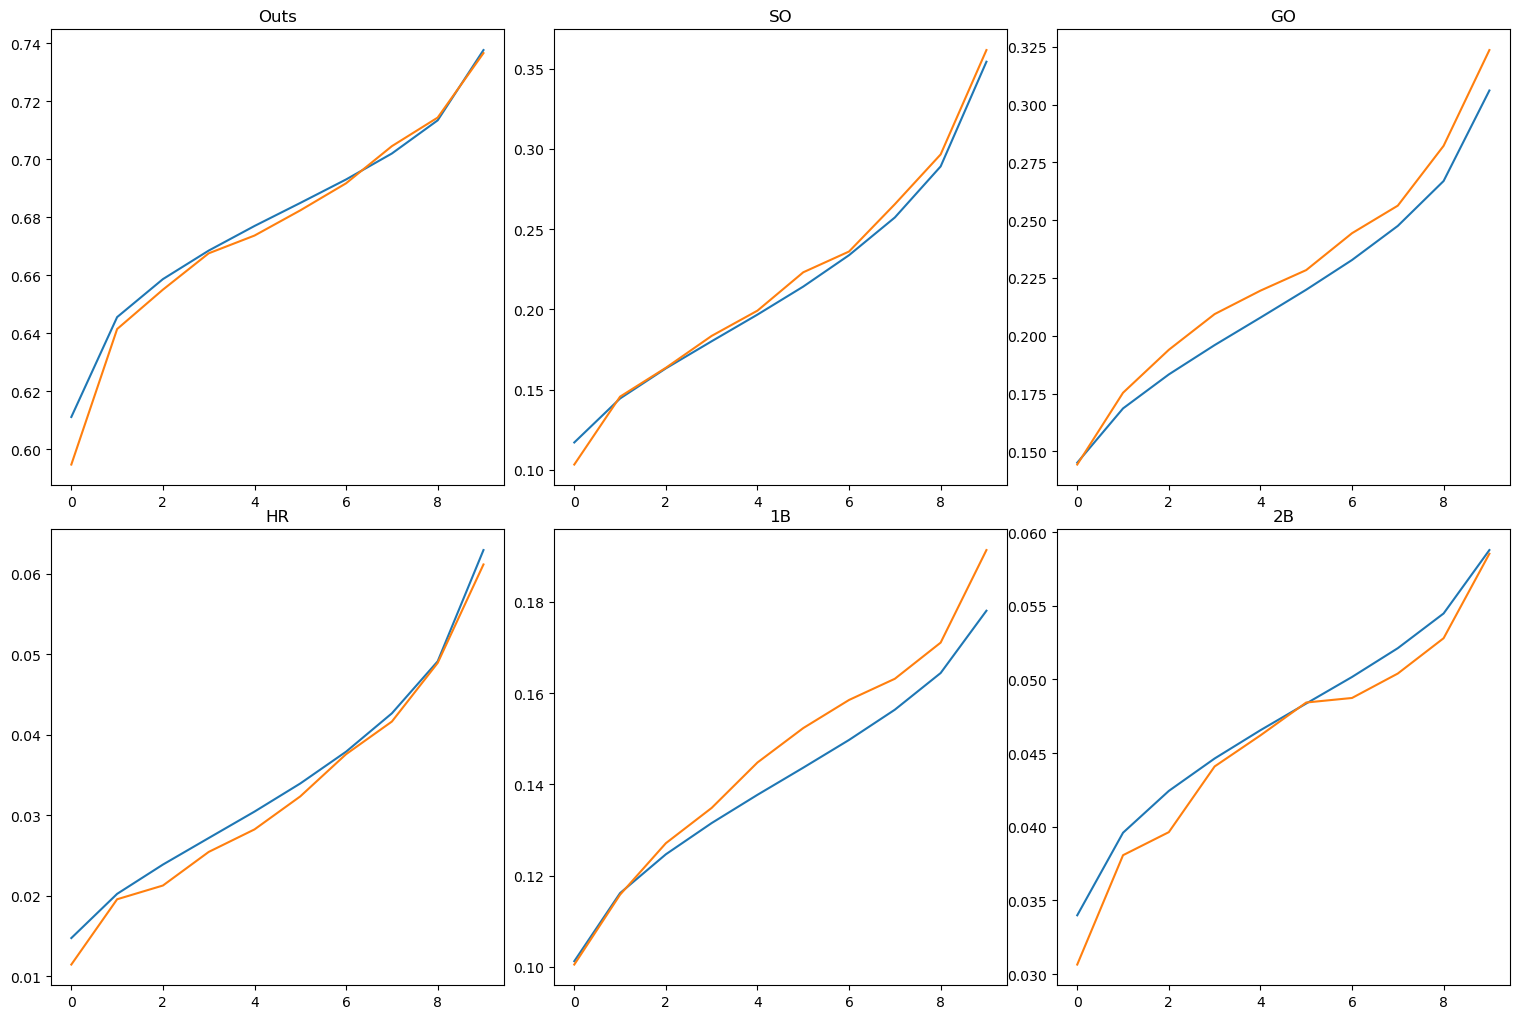

In [55]:
fig, axs = plt.subplots(2, 3, figsize=(15,10))  # Create a grid of 2x2 subplots
# fig.suptitle('A Grid of Subplots')

# # Plot data on each subplot
axs[0, 0].plot(out_df['decile'], out_df['outs'])
axs[0, 0].plot(out_df['decile'], out_df['outs_act'])
axs[0, 0].set_title('Outs')

axs[0, 1].plot(so_df['decile'], so_df['so'])
axs[0, 1].plot(so_df['decile'], so_df['so_act'])
axs[0, 1].set_title('SO')

axs[0, 2].plot(go_df['decile'], go_df['go'])
axs[0, 2].plot(go_df['decile'], go_df['go_act'])
axs[0, 2].set_title('GO')

axs[1, 0].plot(hr_df['decile'], hr_df['hr'])
axs[1, 0].plot(hr_df['decile'], hr_df['hr_act'])
axs[1, 0].set_title('HR')

axs[1, 1].plot(b1_df['decile'], b1_df['b1'])
axs[1, 1].plot(b1_df['decile'], b1_df['b1_act'])
axs[1, 1].set_title('1B')

axs[1, 2].plot(b2_df['decile'], b2_df['b2'])
axs[1, 2].plot(b2_df['decile'], b2_df['b2_act'])
axs[1, 2].set_title('2B')

# Add some space between subplots to prevent overlapping
fig.tight_layout(pad=.0)

# Show the figure
plt.show()

In [ ]:
# # Compute feature importances using permutation importance
# result = permutation_importance(model1b, X_test, y_test, n_repeats=10, random_state=42)
# # Print the feature importances
# listt = []
# for i, feature in enumerate(x_list1):
#     importance = result.importances_mean[i]
#     std = result.importances_std[i]
#     print(f"{feature}: {importance:.5f} +/- {std:.5f}")
#     listt.append([feature, importance, std])

# sorted_list = sorted(listt, key=lambda x: x[1])
# sorted_list

In [ ]:
# # Create a GridSearchCV object
# grid_search = GridSearchCV(cv=5,
#                            estimator=MLPClassifier(max_iter=100),
#                            param_grid={'hidden_layer_sizes': [(50)],
#                            'activation': ['relu'],
#                            'alpha': [0.001]},
#                            scoring=make_scorer(f1_score, average='weighted'), n_jobs=-1, verbose=5)    

# # Fit the GridSearchCV object to the data
# grid_search.fit(X_train_scaled, y_train)

# # Print the best parameter setting
# print(grid_search.best_params_)
# print(grid_search.best_score_)

# # model = MLPClassifier(hidden_layer_sizes=(200,200,200), activation='relu', random_state=1,max_iter=500).fit(X_train_scaled, y_train)
# # preds = model.predict_proba(X_test)

# # print("Train score:", model.score(X_train_scaled, y_train))
# # print("Test score:", model.score(X_test_scaled, y_test))


In [ ]:
# def recall_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     recall = true_positives / (possible_positives + K.epsilon())
#     return recall

# def precision_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     return precision

# def f1_m(y_true, y_pred):
#     precision = precision_m(y_true, y_pred)
#     recall = recall_m(y_true, y_pred)
#     return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# from sklearn.model_selection import TimeSeriesSplit

# # Assume X is your time series data and y is your target variable
# tscv = TimeSeriesSplit(n_splits=5)

# # Loop over each fold
# for train_index, test_index in tscv.split(X):
#     # get the training and test data for this fold
#     X_train, X_test = X.loc[train_index], X.loc[test_index]
#     y_train, y_test = y.loc[train_index], y.loc[test_index]
    
#     # train and evaluate your model on this fold
#     model = MLPClassifier(hidden_layer_sizes=(200,200,200), activation='relu', verbose=True, random_state=1, max_iter=10).fit(X_train, y_train)

#     # model.fit(X_train, y_train)
#     score = model.score(X_test, y_test)
    
#     # do whatever you need to with the score for this fold
#     print("Fold score:", score)